# Single-qubit gate layer learning
This notebook implements the full learning procedure for a layer of single-qubit gates. This involves taking in an arbitrary processor topology and implementing the sweeping algorithm to generate the list of nine Pauli strings that can be used to construct all of the expectation values included in the sparse model. 

In [2]:
import numpy as np
from itertools import permutations, cycle, product
from random import choice, random
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli
from scipy.optimize import curve_fit
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeQuito
import matplotlib.pyplot as plt

In [3]:
#head for the recursive procedure to generate the nine pauli strings
#containing the complete bases for the sparse model
def pauli_strings(adjacency_matrix):
    start_vertex = 0 #start at qubit zero. This could be any outside qubit
    pauli_strings = [['I']*n for i in range(9)] #start with identity
    visited_verts = [] #store the vertices that have been visited
    #call the recursive method and restart it if it dead-ends
    while(True):
        #recursive method
        _getstr(start_vertex, adjacency_matrix, visited_verts, pauli_strings)
        remaining_verts = [v for v in verts if v not in visited_verts] #find unexplored qubits
        if len(remaining_verts) == 0:
            return pauli_strings #if all are explored, return strings
        else: #continue at next unvisited qubit otherwise
            _getstr(remaining_verts[0], adjacency_matrix, visited_verts, pauli_strings)

#recursive method to find pauli strings
def _getstr(vertex, adjacency_matrix, visited_verts, pauli_strings):
    
    #copied from Fig. S3 in van den Berg
    example_orderings = {"XXXYYYZZZ":"XYZXYZXYZ",
                        "XXXYYZZZY":"XYZXYZXYZ",
                        "XXYYYZZZX":"XYZXYZXYZ",
                        "XXZYYZXYZ":"XYZXZYZYX",
                        "XYZXYZXYZ":"XYZZXYYZX"}

    visited_verts.append(vertex) #mark current vertex as visited
    children = [i for i,e in enumerate(adjacency_matrix[vertex]) if e == 1] #get children from edge list
    visited_children = [c for c in children if c in visited_verts] #find intersection with visited qubits

    match len(visited_children):
        case 0: #zero predecessors
            cycp = cycle("XYZ")
            for i,s in enumerate(pauli_strings):
                pauli_strings[i][vertex] = next(cycp)

        case 1: #one predecessor
            predecessor = visited_children[0] #get single predecessor v_j
            #store permutation of indices so that predecessor has X,X,X,Y,Y,Y,Z,Z,Z
            reorder_list = [[] for i in range(3)]
            for i in range(9):
                basis = pauli_strings[i][predecessor]
                reorder_list["XYZ".index(basis)].append(i)
            
            #set the current qubit in the permuted order as X,Y,Z,X,Y,Z,X,Y,Z
            for i in range(3):
                for j,c in enumerate("XYZ"):
                    idx = reorder_list[i][j]
                    pauli_strings[idx][vertex] = c

        case 2: #two predecessors
            predecessor0 = visited_children[0] #choice is arbitrary
            predecessor1 = visited_children[1] #choice is arbitrary

            #use the same reordering trick to get XXXYYYZZZ on first predecessor
            reorder_list = [[] for i in range(3)] 
            for i in range(9):
                basis = pauli_strings[i][predecessor0]
                reorder_list["XYZ".index(basis)].append(i)
            
            #list out string with permuted values of predecessor 2
            substring = ""
            for list in reorder_list:
                for idx in list:
                    substring += pauli_strings[idx][predecessor1]

            #match predecessor two with a permutation of example_orderings
            reordering = ""
            for perm in permutations("XYZ"):
                p_string = "".join(["XYZ"[perm.index(p)] for p in substring])
                if p_string in example_orderings:
                    reordering = example_orderings[p_string]
                    break
            
            #unpermute the example orderings so that they match the original strings
            i = 0
            for list in reorder_list:
                for idx in list:
                    pauli_strings[idx][vertex] = reordering[i]
                    i += 1

        case _: #processor needs to have connectivity so that there are <= 2 predecessors
            raise Exception("Three or more predecessors encountered")
    
    for c in children: #call recursive method on children
        if c not in visited_children:
            _getstr(c, adjacency_matrix, visited_verts, pauli_strings)

    return

#create a list of all paulis with support on connected qubits    
def generate_paulis(adjacency_matrix):
    n = len(adjacency_matrix)
    pauli_list = []
    idPauli = ['I']*n    
    
    #get all single-weight paulis
    for i in range(n):
        for op in ['X','Y','Z']:
            pauli = idPauli.copy()
            pauli[i] = op
            pauli_list.append("".join(pauli))
            
    #get all weight-two paulis on nieghboring qubits
    for vert1,link in enumerate(adjacency_matrix):
        for vert2,val in enumerate(link[:vert1]):
            if val == 1:
                for pauli1, pauli2 in product(['X','Y','Z'], repeat = 2):
                    pauli = idPauli.copy()
                    pauli[vert1] = pauli1
                    pauli[vert2] = pauli2
                    pauli_list.append("".join(pauli))

    return pauli_list

In [4]:
#generate a twirled circuit instance with l layers
def twirled_circuit(n : int, l : int) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    ops = [Pauli('I')]*n
    #iterate over the layers
    for j in range(l-1):
        #iterate over the qubits
        for i in range(n):
            #choose a random single-qubit Pauli
            p = Pauli(choice(['I','X','Y','Z']))
            #chain the layers together so that the last half of the previous
            #cycle is combined with the first half of the next
            op = ops[i].compose(p)
            qc.append(Pauli([op.z],[op.x]), [i]) #this trick gets rid of the phase
            ops[i] = p
    qc.barrier()
    #fill in the last layer so that the logical circuit is the identity
    for i in range(n):
        op = ops[i] 
        qc.append(Pauli([op.z],[op.x]), [i])
    return qc

#This implements the readout twirling procedure to diagonalize the readout errors
# in the readout basis.
def twirled_readout(n):
    qc = QuantumCircuit(n)
    #this string is returned to get the adjusted result of running the circuit
    binstr = ""
    for i in range(n):
        r = random()
        #sample unifromly from {X,I}
        if r < .5:
            qc.x(i)
            #record the bit flips
            binstr += '1'
        else:
            qc.id(i)
            binstr += '0'
    return(qc, binstr)

In [5]:
#generate pauli measurement circuitry with corresponding metadata
def twirled_instance(n, pauli, length):
    n = len(qubits)

    qc = QuantumCircuit(n)
    #switch to pauli basis
    for k,p in enumerate(pauli):
        match p:
            case 'X':
                qc.h(k)
            case 'Y':
                qc.h(k)
                qc.s(k)
            case 'Z':
                qc.id(k)
    qc.barrier()
    #add the twirled layers
    tw = twirled_circuit(n,length)
    qc = qc.compose(tw)

    qc.barrier()
    #switch to measurement basis
    for k,p in enumerate(pauli):
        match p:
            case 'X':
                qc.h(k)
            case 'Y':
                qc.sdg(k)
                qc.h(k)
            case 'Z':
                qc.id(k)
    #add the readout layer
    qc.barrier()
    ro, binstr = twirled_readout(n)
    qc = qc.compose(ro)

    qc.measure_all()
    #transpile the circuits
    info = {'qubits':qubits, 'pauli':pauli, 'rostring':binstr, 'length':length}

    return (qc,info)

In [6]:
#compute the binary sum of two bitstrings
def oplus(binstr1, binstr2):
    result = ""
    for i,b in enumerate(binstr2):
        if binstr1[i] == '1':
            result += {'0':'1','1':'0'}[b]
        else:
            result += b
    return result

def dot(binstr1, binstr2):
    return np.sum([{('1','1'):1}.get(pair, 0) for pair in zip(binstr1, binstr2)])

def get_expectation(circuit_data, pauli):
    pauli_weight = "".join([{'I':'0'}.get(p, '1') for p in pauli])
    counts = circuit_data['counts']
    rostring = circuit_data['rostring']
    expec = np.sum([counts[key]*(-1)**dot(oplus(key[::-1],rostring), pauli_weight) for key in counts.keys()])
    return expec

In [7]:
backend = AerSimulator.from_backend(FakeQuito())
qubits = [0,1,2] #coinciding with the gate layer
connections = [(0,1),(1,2)]
n = len(qubits)

unmapped = lambda i: qubits.index(i)
verts = [unmapped(qubit) for qubit in qubits]
edges = [(unmapped(qubit1), unmapped(qubit2)) for qubit1,qubit2 in connections]
mapped = lambda i: verts[i]
#change adjacency list to matrix
adjacency_matrix = [[0 for i in verts] for j in verts] 
for (vert1,vert2) in edges:
    adjacency_matrix[vert1][vert2] = 1
    adjacency_matrix[vert2][vert1] = 1

degrees = [adjacency_matrix[vert].count(1) for vert in verts]

In [8]:
pauli_measurements = pauli_strings(adjacency_matrix)
benchmark_paulis = generate_paulis(adjacency_matrix)

In [9]:
circs = []
data = []
lengths = [2,4, 8, 16,32,64,128]
samples = 64
shots = 100

for p in pauli_measurements:
    for l in lengths: 
        for i in range(samples):
            circ, circ_info =  twirled_instance(len(qubits), "".join(p), l)
            circs.append(circ)
            data.append(circ_info)

In [10]:
trans =  transpile(circs, backend, optimization_level=0, initial_layout = qubits)

In [11]:
results = backend.run(trans, shots = shots).result().get_counts()
for i,res in enumerate(results):
    data[i]['counts'] = res

In [12]:
ordered_results = {}
for p in benchmark_paulis:
    ordered_results[p] = {}
    for l in lengths:
        ordered_results[p][l] = {}
        ordered_results[p][l]["count"] = 0 
        ordered_results[p][l]["total"] = 0 

for datum in data:
    #check each pauli in benchmarks for compatible overlap
    instance = dict()
    for p in benchmark_paulis:
        #check if non-identity terms in p overlap with instance
        if all([c1 == c2 for c1,c2 in zip(p, datum['pauli']) if not c1 == 'I']):
            ordered_results[p][datum['length']]['count'] += get_expectation(datum, p)
            ordered_results[p][datum['length']]['total'] += sum(list(datum['counts'].values()))

for p in benchmark_paulis:
    for l in lengths:
        ordered_results[p][l]['count'] /= ordered_results[p][l]['total']
        

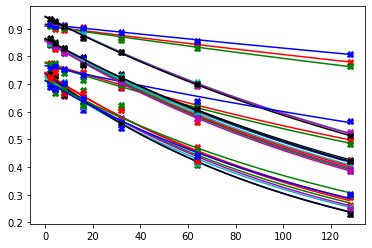

In [27]:
color = cycle("rgbcmk")
xrange = np.linspace(0, np.max(lengths))
show_paulis = benchmark_paulis
fit_data = {}
for p in show_paulis:
    vals = [ordered_results[p][l]['count'] for l in lengths]
    popt, pcov = curve_fit(lambda x,a,b: a*np.exp(-b*x), lengths, vals, p0=[.8, .01])
    fit_data[p] = np.exp(-popt[1])
    c = next(color)
    plt.plot(lengths, vals, c+"X")
    plt.plot(xrange, [popt[0]*np.exp(-popt[1]*x) for x in xrange], c)

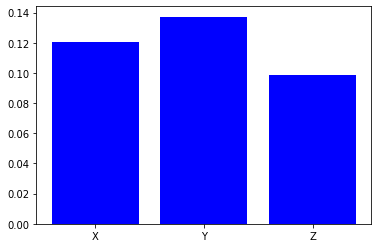

In [34]:
show_paulis = [j+"II" for j in "XYZ"]
for p in show_paulis:
    plt.bar(p[0], 100*(1-fit_data[p]), color='b')


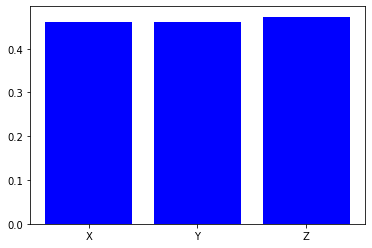

In [36]:
show_paulis = ["I"+j+"I" for j in "XYZ"]
for p in show_paulis:
    plt.bar(p[1], 100*(1-fit_data[p]), color = 'b')

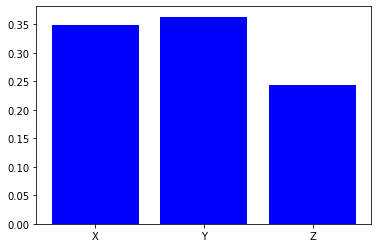

In [37]:
show_paulis = ["II"+j for j in "XYZ"]
for p in show_paulis:
    plt.bar(p[2], 100*(1-fit_data[p]), color = 'b')

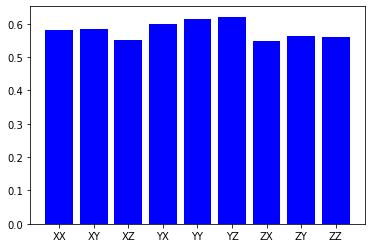

In [38]:
show_paulis = [x + y + "I" for x in "XYZ" for y in "XYZ"]
for p in show_paulis:
    plt.bar(p[:2], 100*(1-fit_data[p]), color='b')

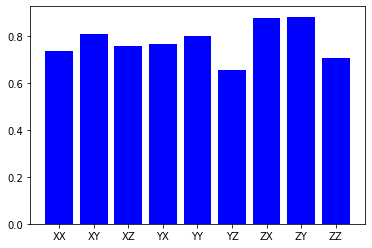

In [39]:
show_paulis = ["I"+x+y for x in "XYZ" for y in "XYZ"]
for p in show_paulis:
    plt.bar(p[1:], 100*(1-fit_data[p]), color = 'b')